In [ ]:
! pip install celluloid

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML
%matplotlib inline

In [ ]:
def cuda2numpy(a):
    return a.data.detach().cpu().numpy()

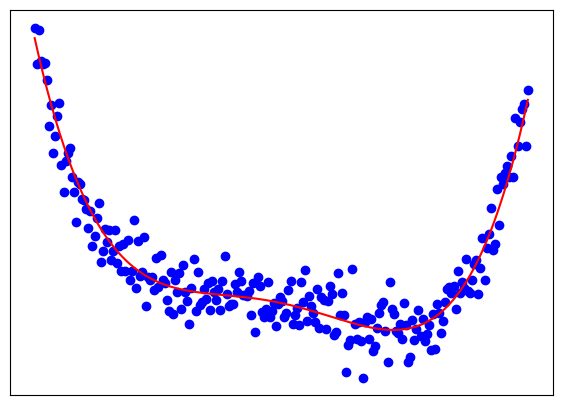

In [ ]:
x = torch.arange(-6.0, 6.0, 0.05)
y = 0.1*(x**3) - 2*((x+2)**2) + 1*x + 3+0.2*(x)**4
y_noise = 15 * torch.randn(x.shape[0])
ydata = y + y_noise
plt.figure(figsize=(7,5))
plt.plot(x, ydata,  'bo')
plt.plot(x, y, 'r')
plt.xticks([]);plt.yticks([])

ydata = ydata.unsqueeze(1)
x = x.unsqueeze(1)

In [ ]:
class MLP(nn.Module):
  def __init__(self,architecture=[1,100,1],activation='sigmoid'):
        super(MLP, self).__init__()
        self.architecture = architecture
        if activation == 'sigmoid':
          self.activation = nn.Sigmoid()
        elif activation == 'relu':
          self.activation = nn.ReLU()
        else:
          print('Activation not recognized. Using LeakyReLU instead.')
          self.activation = nn.LeakyReLU()
        arch=[]
        for i in range(1,len(architecture)-1):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))
            arch.append(self.activation)
        self.basis=nn.Sequential(*arch)
        self.regressor=nn.Linear(architecture[-2],architecture[-1])

  def forward(self,f):
        assert f.shape[1] == self.architecture[0]
        z = self.basis(f)
        out = self.regressor(z)
        return out

In [ ]:
lr = 1e-2
n_epochs = 7500
model = MLP([1,25,1],activation='sigmoid')
optim = torch.optim.SGD(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[1000, 2500, 5000], gamma=0.5)

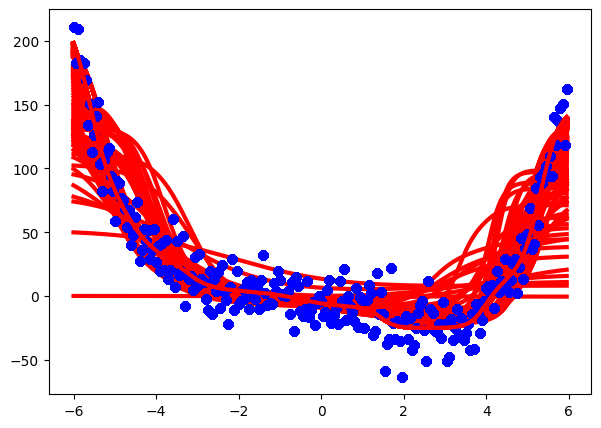

In [ ]:
objective = nn.MSELoss()
fig = plt.figure(figsize=(7,5))
camera = Camera(fig)
for n in range(n_epochs):
  f = model(x)
  loss = objective(f,ydata)
  optim.zero_grad()
  loss.backward()
  optim.step()
  if np.mod(n,25) == 0:
    plt.plot(x, ydata, 'bo')
    plt.plot(x, cuda2numpy(f), 'r', linewidth=3)
    camera.snap()
  scheduler.step()

In [ ]:
anim = camera.animate(interval=40, repeat=True, repeat_delay=500)
HTML(anim.to_html5_video())

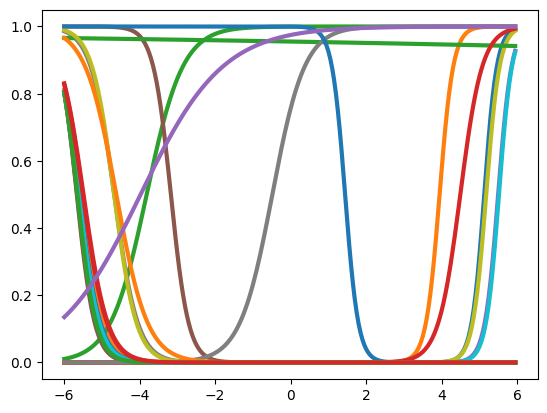

In [ ]:
basis = cuda2numpy(model.basis(x))
for i in range(basis.shape[1]):
  plt.plot(x,basis[:,i],linewidth=3)
plt.show()

## Solution

### Part-1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import cv2

In [ ]:
img_path = '/content/moon.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = img / 255.0

In [ ]:
x = np.linspace(0, 1, 256)
y = np.linspace(0, 1, 256)
X, Y = np.meshgrid(x, y)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
grayscale_values = img.reshape(-1, 1)

In [ ]:
input_features = np.hstack((X, Y))
input_features = torch.FloatTensor(input_features)
grayscale_values = torch.FloatTensor(grayscale_values)

## Part-2

In [ ]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.sin(30 * self.fc1(x))
        x = torch.sin(30 * self.fc2(x))
        x = self.fc3(x)
        return x

## Part-3

In [ ]:
epochs = 1000
learning_rate = 0.01
batch_size = 256

model = MLPModel()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[250, 500], gamma=0.1)
criterion = nn.MSELoss()

## Part-4

In [ ]:
losses = []

for epoch in range(epochs):
    perm = torch.randperm(input_features.size(0))
    for i in range(0, input_features.size(0), batch_size):
        indices = perm[i : i + batch_size]
        batch_X, batch_y = input_features[indices], grayscale_values[indices]
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    scheduler.step()

## Part-5

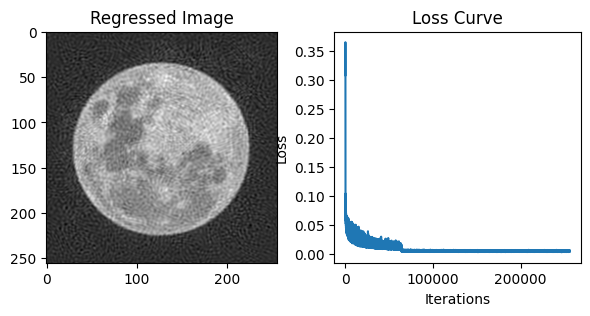

In [ ]:
final_img = model(input_features).detach().numpy().reshape(256, 256)
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.imshow(final_img, cmap='gray')
plt.title('Regressed Image')
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

## Part-6

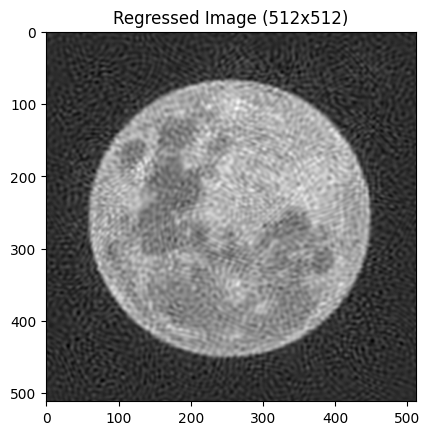

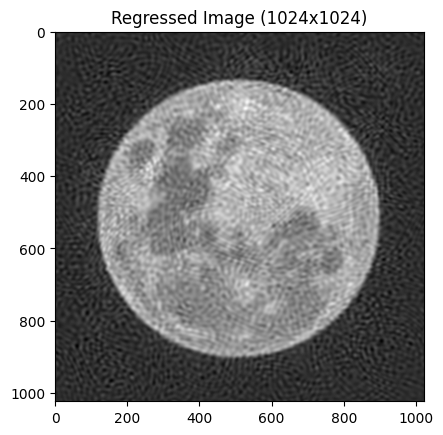

In [ ]:
def evaluateModel(res):
    x_eval = np.linspace(0, 1, res)
    y_eval = np.linspace(0, 1, res)
    X_eval, Y_eval = np.meshgrid(x_eval, y_eval)
    X_eval = X_eval.reshape(-1, 1)
    Y_eval = Y_eval.reshape(-1, 1)
    input_features_eval = np.hstack((X_eval, Y_eval))
    input_features_eval = torch.FloatTensor(input_features_eval)

    regressed_image_eval = model(input_features_eval).detach().numpy().reshape(res, res)
    plt.imshow(regressed_image_eval, cmap='gray')
    plt.title(f'Regressed Image ({res}x{res})')
    plt.show()

evaluateModel(512)
evaluateModel(1024)